### Image classification using Fashion MNIST data set
#### Classification of hard items using random erase for regularization

Results indicate that 4 of the item classes - 0: T-shirt/top, 2: Pullover, 4: Coat, and 6: Shirt - are harder to classify; 
test accuracy for these items are about 89%, while other items are classified with about 98% accuracy. 

In this notebook we use random erase method for regularization and train 5 models for 100 epochs to investigate whether classification accuracy for these hard classes can be improved.

We find that this approach increases classification accuracy for these hard to classify items from 89% to 93.5%





In [0]:
# Import
import os # for file handling
import pandas as pd # for data handling
import numpy as np # for linear algebra
import time # to time runs
import matplotlib.pyplot as plt # to display plots
from sklearn import metrics # to evaluate classification accuracy
from sklearn.model_selection import train_test_split # for validation data
import tensorflow as tf # for neural networks
# import from keras:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout
# for on-line image generation (data augmentation)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Get data

In [11]:
# get fashion mnist data
(x_train,y_train), (x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()

# show shapes of tensors
print("x_train shape:", x_train.shape, ", y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape, ", y_test shape:", y_test.shape)

# get number of classes
nClasses = len(np.unique(y_train)) # number of output classes
print("Number of classes: ", nClasses)

x_train shape: (60000, 28, 28) , y_train shape: (60000,)
x_test shape: (10000, 28, 28) , y_test shape: (10000,)
Number of classes:  10


#### Isolate hard cases

In [12]:
# specify label for classes
items = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 
         'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
item = dict(zip(range(10), items))
for i in item:
  print(i, item[i])
  
hardClasses = [0,2,4,6] # classes with low classification accuracy

# get indices of hard examplesin training and test data
hardIndxTrain = [i for i in range(len(y_train)) if y_train[i] in hardClasses]
hardIndxTest = [i for i in range(len(y_test)) if y_test[i] in hardClasses]
print('Train data contains %d and test data contains %d hard examples' 
      %(len(hardIndxTrain), len(hardIndxTest)))

# retain only hard examples
x_train, y_train = x_train[hardIndxTrain], y_train[hardIndxTrain]
x_test, y_test = x_train[hardIndxTest], y_train[hardIndxTest]

0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot
Train data contains 24000 and test data contains 4000 hard examples


#### Map old labels to new labels

In [13]:
newClass = {0:0, 2:1, 4:2, 6:3} # new labels 
oldClass = {0:0, 1:2, 2:4, 3:6} # recover old labels

y_train = [newClass[c] for c in y_train]
y_test = [newClass[c] for c in y_test]

# get number of classes
nClasses = len(np.unique(y_train)) # number of output classes
print("Number of classes: ", nClasses)

Number of classes:  4


#### Pre-process data

In [14]:
# normalize grayscale pixel values (0-255) to (0,1)
x_train = x_train.astype('float32')/255 # normalized training inputs
x_test = x_test.astype('float32')/255 # normalized test inputs

# reshape to needed input shape for network
x_train, x_test = x_train.reshape((-1,28,28,1)), x_test.reshape((-1,28,28,1))
input_shape = x_train.shape[1:] # input shape for network

# reserve some training data for validation
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=1/6) # 1/6 reserved for validation

# reshape output to output one-hot representation needed for network
y_train = tf.keras.utils.to_categorical(y_train, nClasses)
y_valid = tf.keras.utils.to_categorical(y_valid, nClasses)
y_test = tf.keras.utils.to_categorical(y_test, nClasses)

# show shapes of re-shaped tensors
print("x_train shape:", x_train.shape, ", y_train shape:", y_train.shape)
print("x_valid shape:", x_valid.shape, ", y_valid shape:", y_valid.shape)
print("x_test shape:", x_test.shape, ", y_test shape:", y_test.shape)

# get image dimensions
img_h, img_w, img_channels = x_train.shape[1:] # size of image
print("Image height = %d, image width = %d, number of channels = %d" 
      %(img_h, img_w, img_channels))

x_train shape: (20000, 28, 28, 1) , y_train shape: (20000, 4)
x_valid shape: (4000, 28, 28, 1) , y_valid shape: (4000, 4)
x_test shape: (4000, 28, 28, 1) , y_test shape: (4000, 4)
Image height = 28, image width = 28, number of channels = 1


#### Define function to create Convolution Neural Network

In [0]:
def convNN(model, ch1, ch2, kernel, pool, nDense, drop, dropDense):
  """returns CNN model with specified architecture and parameters"""

  model = tf.keras.models.Sequential() # create model                

  # first CONV => RELU => CONV => RELU => POOL layer set
  model.add(Conv2D(ch1, kernel, padding="same", 
                   activation="relu", input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(Conv2D(ch1, kernel, padding="same", activation="relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=pool))
  model.add(tf.keras.layers.Dropout(drop))

  # second CONV => RELU => CONV => RELU => POOL layer set
  model.add(Conv2D(ch2, kernel, padding="same", 
                   activation="relu", input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(Conv2D(ch2, kernel, padding="same", activation="relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=pool))
  model.add(tf.keras.layers.Dropout(drop))

  model.add(tf.keras.layers.Flatten()) 

  # FC => RELU layers
  model.add(tf.keras.layers.Dense(nDense, activation='relu'))
  model.add(BatchNormalization())
  model.add(tf.keras.layers.Dropout(dropDense))

  # output softmax layer
  model.add(tf.keras.layers.Dense(nClasses, activation='softmax'))

  model.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adadelta(),
                metrics=['accuracy'])

  return model

#### Specify parameters for convolution network

In [17]:
# Parameters for CNN models (change as desired)
ch1, ch2 = 32, 64 # number of output channels
kernel = (3,3) # filter shape
pool = (2,2) # max pool size
nDense = 512 # dense layer size
drop, dropDense = 0.25, 0.5

# create model
mod = convNN('model', ch1, ch2, kernel, pool, nDense, drop, dropDense)
mod.summary() # show model summary

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_v1_10 (B (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_v1_11 (B (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 64)        18496     
__________

#### Define function for data augmentation and regularization through random erasing
- Randomly selected rectangular sections are erased from images
- Souce: https://github.com/yu4u/cutout-random-erasing/blob/master/random_eraser.py
-  Implements method described in:

> -   T. DeVries and G. W. Taylor, "Improved Regularization of Convolutional Neural Networks with Cutout," in arXiv:1708.04552, 2017.

> -    Z. Zhong, L. Zheng, G. Kang, S. Li, and Y. Yang, "Random Erasing Data Augmentation," in arXiv:1708.04896, 2017.

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, 
                      v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

#### Create real time data generator for images with random erasing
- > https://keras.io/preprocessing/image/#imagedatagenerator-class
- > see: https://github.com/yu4u/cutout-random-erasing/blob/master/cifar10_resnet.py

In [0]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # do not rotate images
    width_shift_range=0.1,  # randomly shift images horizontally by 0.1 of width
    height_shift_range=0.1,  # randomly shift images vertically by 0.1 of height
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False))

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

#### Define function to plot accuracy with training and validation data 

In [0]:
def plotHistorty(model, history):
    # plot history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(model+' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#### Specify parameters for training

In [0]:
batchSize = 32 # batch size for training
epochs = 100 # number of training epochs

#### Train CNN models with random erasing


Training Model: hard_model_random_erase1

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
4000/4000 [==============================] - 1s 135us/sample - loss: 0.6714 - acc: 0.7237

Epoch 00001: val_acc improved from -inf to 0.72375, saving model to hard_model_random_erase1.weights.hdf5
625/625 [==============================] - 12s 19ms/step - loss: 1.0958 - acc: 0.5844 - val_loss: 0.6714 - val_acc: 0.7237
Epoch 2/100
4000/4000 [==============================] - 1s 139us/sample - loss: 0.6130 - acc: 0.7500

Epoch 00002: val_acc improved from 0.72375 to 0.75000, saving model to hard_model_random_erase1.weights.hdf5
625/625 [==============================] - 10s 16ms/step - loss: 0.7680 - acc: 0.6809 - val_loss: 0.6130 - val_acc: 0.7500
Epoch 3/100
4000/4000 [==============================] - 0s 113us/sample - loss: 0.5188 - acc: 0.7855

Epoch 00003: val_acc improved from 0.75000 to 0.78550, saving model to hard_model_random_erase1.weights.hdf5
625/625 [=====================

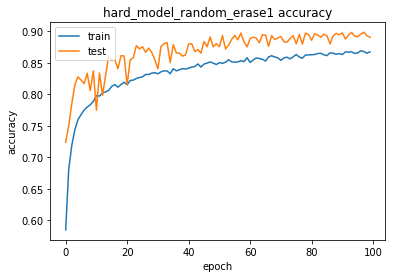


Training Model: hard_model_random_erase2

Epoch 1/100
4000/4000 [==============================] - 1s 140us/sample - loss: 0.7176 - acc: 0.6992

Epoch 00001: val_acc improved from -inf to 0.69925, saving model to hard_model_random_erase2.weights.hdf5
625/625 [==============================] - 10s 16ms/step - loss: 1.0653 - acc: 0.5972 - val_loss: 0.7176 - val_acc: 0.6992
Epoch 2/100
4000/4000 [==============================] - 0s 109us/sample - loss: 0.5549 - acc: 0.7720

Epoch 00002: val_acc improved from 0.69925 to 0.77200, saving model to hard_model_random_erase2.weights.hdf5
625/625 [==============================] - 9s 14ms/step - loss: 0.7603 - acc: 0.6891 - val_loss: 0.5549 - val_acc: 0.7720
Epoch 3/100
4000/4000 [==============================] - 0s 105us/sample - loss: 0.5262 - acc: 0.7845

Epoch 00003: val_acc improved from 0.77200 to 0.78450, saving model to hard_model_random_erase2.weights.hdf5
625/625 [==============================] - 9s 14ms/step - loss: 0.6793 - acc: 0

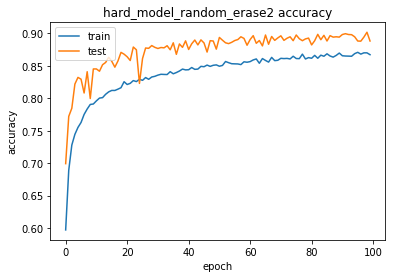


Training Model: hard_model_random_erase3

Epoch 1/100
4000/4000 [==============================] - 1s 156us/sample - loss: 0.7057 - acc: 0.6942

Epoch 00001: val_acc improved from -inf to 0.69425, saving model to hard_model_random_erase3.weights.hdf5
625/625 [==============================] - 10s 17ms/step - loss: 1.0676 - acc: 0.5878 - val_loss: 0.7057 - val_acc: 0.6942
Epoch 2/100
4000/4000 [==============================] - 0s 107us/sample - loss: 0.5701 - acc: 0.7715

Epoch 00002: val_acc improved from 0.69425 to 0.77150, saving model to hard_model_random_erase3.weights.hdf5
625/625 [==============================] - 9s 14ms/step - loss: 0.7506 - acc: 0.6931 - val_loss: 0.5701 - val_acc: 0.7715
Epoch 3/100
4000/4000 [==============================] - 0s 104us/sample - loss: 0.5111 - acc: 0.7965

Epoch 00003: val_acc improved from 0.77150 to 0.79650, saving model to hard_model_random_erase3.weights.hdf5
625/625 [==============================] - 9s 14ms/step - loss: 0.6805 - acc: 0

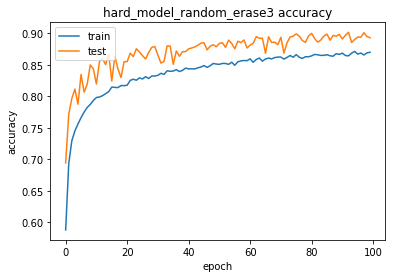


Training Model: hard_model_random_erase4

Epoch 1/100
4000/4000 [==============================] - 1s 148us/sample - loss: 0.6980 - acc: 0.7147

Epoch 00001: val_acc improved from -inf to 0.71475, saving model to hard_model_random_erase4.weights.hdf5
625/625 [==============================] - 11s 17ms/step - loss: 1.1073 - acc: 0.5801 - val_loss: 0.6980 - val_acc: 0.7147
Epoch 2/100
4000/4000 [==============================] - 0s 110us/sample - loss: 0.5523 - acc: 0.7803

Epoch 00002: val_acc improved from 0.71475 to 0.78025, saving model to hard_model_random_erase4.weights.hdf5
625/625 [==============================] - 9s 14ms/step - loss: 0.7695 - acc: 0.6848 - val_loss: 0.5523 - val_acc: 0.7803
Epoch 3/100
4000/4000 [==============================] - 0s 105us/sample - loss: 0.6267 - acc: 0.7515

Epoch 00003: val_acc did not improve from 0.78025
625/625 [==============================] - 8s 14ms/step - loss: 0.6899 - acc: 0.7230 - val_loss: 0.6267 - val_acc: 0.7515
Epoch 4/100
4000

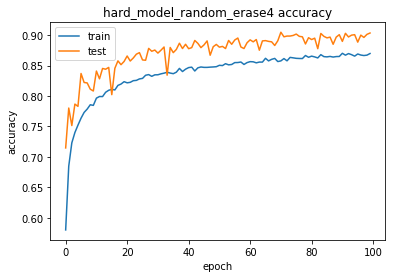


Training Model: hard_model_random_erase5

Epoch 1/100
4000/4000 [==============================] - 1s 168us/sample - loss: 0.6756 - acc: 0.7268

Epoch 00001: val_acc improved from -inf to 0.72675, saving model to hard_model_random_erase5.weights.hdf5
625/625 [==============================] - 12s 19ms/step - loss: 1.0891 - acc: 0.5838 - val_loss: 0.6756 - val_acc: 0.7268
Epoch 2/100
4000/4000 [==============================] - 0s 112us/sample - loss: 0.7246 - acc: 0.7128

Epoch 00002: val_acc did not improve from 0.72675
625/625 [==============================] - 9s 14ms/step - loss: 0.7614 - acc: 0.6900 - val_loss: 0.7246 - val_acc: 0.7128
Epoch 3/100
4000/4000 [==============================] - 0s 104us/sample - loss: 0.6020 - acc: 0.7663

Epoch 00003: val_acc improved from 0.72675 to 0.76625, saving model to hard_model_random_erase5.weights.hdf5
625/625 [==============================] - 9s 14ms/step - loss: 0.6778 - acc: 0.7276 - val_loss: 0.6020 - val_acc: 0.7663
Epoch 4/100
4000

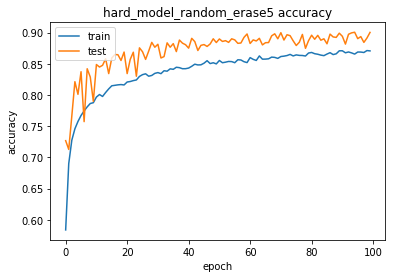

In [22]:
nModels = 5 # number of models to train
probs = np.zeros((len(y_test), nClasses)) # mean probabilities for classes
result = [] # for results

yt = np.argmax(y_test, axis = 1) # true class for test data

for i in range(nModels): 
  model = 'hard_model_random_erase'+str(i+1) # model name
  print('\nTraining Model: '+ model + '\n')
  bestWts = model+".weights.hdf5" # best weights file
  
  # checkpoint to save best model
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=bestWts,
                                                  monitor='val_acc',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode='max')
  callbacks = [checkpoint]
  
  # create model
  mod = convNN(model, ch1, ch2, kernel, pool, nDense, drop, dropDense)
  
  st = time.time() # start time for training
  
  # train with augmented data and maintain history
  hist = mod.fit_generator(datagen.flow(x_train, y_train, batch_size=batchSize),
                           steps_per_epoch=x_train.shape[0] // batchSize,
                           validation_data=(x_valid, y_valid),
                           epochs=epochs, verbose=1,
                           callbacks=callbacks)
  
  t = time.time() - st # time to train model
  
  print("\nTime to train classifier: %4.2f seconds\n" %(t))
  
  mod.save_weights(bestWts) # save best weigths
  
  prob = mod.predict(x_test) # predict probabilities for test examples
  predicted = prob.argmax(axis=1) # mst likely class
  
  acc = metrics.accuracy_score(yt, predicted) # test accuracy 
  print('%s Test accuracy = %4.2f%%\n\n' %(model, acc*100.0))
  
  probs += prob # compute aggregate probability for classes
  predicted = probs.argmax(axis=1) # most likely class
  accCum = metrics.accuracy_score(yt, predicted) # test accuracy 
  print('%s Gestalt Test accuracy = %4.2f%%\n\n' %(model,accCum*100.0))
  
  result.append([model,acc,accCum,t])
  plotHistorty(model, hist) # display training and test accuracy

#### Show results on model accuracy, cumulative accuracy, and training time

In [23]:
result = pd.DataFrame(result, 
                      columns=['model', 'accuracy', 'cum. accuracy', 'time'])
result

,model,accuracy,cum. accuracy,time
0,hard_model_random_erase1,0.91525,0.91525,903.716963
1,hard_model_random_erase2,0.91250,0.92000,887.891403
2,hard_model_random_erase3,0.91900,0.92550,888.479018
3,hard_model_random_erase4,0.92800,0.92925,887.289185
4,hard_model_random_erase5,0.93000,0.93525,892.044436


#### specify label for classes

In [0]:
HardItems = ['T-shirt/top', 'Pullover', 'Coat', 'Shirt'] # labels

#### Show confusion matrix

In [25]:
cm = metrics.confusion_matrix(yt, predicted)
cm = pd.DataFrame(cm, columns=HardItems)
cm.insert(0,"True",HardItems)
cm

,True,T-shirt/top,Pullover,Coat,Shirt
0,T-shirt/top,894,3,1,81
1,Pullover,2,909,34,25
2,Coat,0,10,977,15
3,Shirt,36,15,37,961


#### Show classification report

In [26]:
print(metrics.classification_report([HardItems[i] for i in yt], 
                                    [HardItems[i] for i in predicted]))

              precision    recall  f1-score   support

        Coat       0.93      0.98      0.95      1002
    Pullover       0.97      0.94      0.95       970
       Shirt       0.89      0.92      0.90      1049
 T-shirt/top       0.96      0.91      0.94       979

   micro avg       0.94      0.94      0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000



#### Use mode class for prediction

In [27]:
predClass = pd.DataFrame()
for i in range(nModels):
  model = 'hard_model_random_erase'+str(i+1)
  print("processing " + model)
  bestWts = model+".weights.hdf5" # best weights file
  mod.load_weights(bestWts) # load best weights
  prob = mod.predict(x_test) # predict probabilities for test examples
  predClass[model] = prob.argmax(axis=1) # mst likely class
  
modeClass = predClass.mode(axis=1)
modeAcc = metrics.accuracy_score(yt, modeClass[0])
print("Accuracy based on mode class = %4.2f%%" %(100.0*modeAcc))

processing hard_model_random_erase1
processing hard_model_random_erase2
processing hard_model_random_erase3
processing hard_model_random_erase4
processing hard_model_random_erase5
Accuracy based on mode class = 93.47%
